In [1]:
import numpy as np # giving an alas
import matplotlib.pyplot as plt
from model import calculate_fitness, r0, nyear, cg, phi, epsilon, gamma, lam, n_char, deg_to_km # to check fitness inside reverse learning

In [2]:
# these 2 varibles givin in the document already
a_chaos = 0.5
b_chaos = 2.2

In [3]:
# these the boundrys given
LOWER_BOUND = np.array([113.8, 22.45]) 
UPPER_BOUND = np.array([114.4, 22.85])

In [4]:
def circle_chaotic_map(dim, n_pop):
	
	z = np.random.rand(n_pop, dim)

	term1 = b_chaos / (2 * np.pi)
	term2 = np.sin(2 * np.pi * z) # using eq11

	new_z = z + a_chaos - (term1 * term2) # than assamble in 1 varible 
	chaotic_pop = new_z % 1 # to kkep it between 0 and 1
    
	# one single whale in our code represents 14 different stations all at once it makes an array of 28, but we have 2, x and y cordinates, we will stretch it 14 times to reach same width as whale array 	 
	lb_tiled = np.tile(LOWER_BOUND, int(dim/2))
	ub_tiled = np.tile(UPPER_BOUND, int(dim/2))
    
	scaled_pop = lb_tiled + chaotic_pop * (ub_tiled - lb_tiled) # scaling part 
    
	return scaled_pop

In [5]:
def get_tent_random(size):

    z = np.random.rand(*size) # we should first randomize to get a number
    
    tent_values = np.where(z < 0.5, 2 * z, 2 * (1 - z)) # apply eq12
    
    return tent_values

In [6]:
def apply_reverse_learning(population, fitness_scores, demand_points):

	n_pop = population.shape[0]
	dim = population.shape[1]

	# one single whale in our code represents 14 different stations all at once it makes an array of 28, but we have 2, x and y cordinates, we will stretch it 14 times to reach same width as whale array
	lb_tiled = np.tile(LOWER_BOUND, int(dim/2))
	ub_tiled = np.tile(UPPER_BOUND, int(dim/2))

	# paper say we have to sort the population acoording to the fitness value from best lower cost to worst higher cost
	sorted_indices = np.argsort(fitness_scores)
	sorted_pop = population[sorted_indices]
	sorted_fitness = fitness_scores[sorted_indices]

	# ratio is 1 3 6
	limit_layer1 = int(n_pop * 0.1) # cut top 10
	limit_layer2 = int(n_pop * 0.4) # cut top 40 (30 + 10) 10 coming from layer 1 
    
	# giving them to new varibles
	new_pop = sorted_pop.copy()
	new_fitness = sorted_fitness.copy()

	for i in range(n_pop): # this is the top part we do nothing to them they are ok
		if i < limit_layer1:
			continue

		original_whale = sorted_pop[i]
		reverse_whale = (lb_tiled + ub_tiled) - original_whale # we are calculating opposite side of the map by eq13
        
		reverse_whale = np.clip(reverse_whale, lb_tiled, ub_tiled) # this will ensure we are not outside of the map
        
		stations_reshaped = reverse_whale.reshape(12, 2) # ok we got new position reshaped
		rev_fit = calculate_fitness(stations_reshaped, demand_points) # but is it any better
        
		if limit_layer1 <= i < limit_layer2: # for middle layer we compare it old fitness with new calculated one, if new one better we replace it, eq14 says so
			if rev_fit < sorted_fitness[i]:
				new_pop[i] = reverse_whale
				new_fitness[i] = rev_fit
                
		else: # aha bottom layer, this time we will caculate opposite but do not check if its better because its already bad 
			new_pop[i] = reverse_whale
			new_fitness[i] = rev_fit
            
		return new_pop, new_fitness

In [7]:
def iwoa_solve(demand_points, max_iter=100, pop_size=30, dim=24): # we will take 130 demand ppoint, set for 100 for now, use 30 whales, 29 dimention

	print(f"Starting IWOA Optimization for {max_iter} iterations")

	# Initialize Population (Section 2.2.1)
	population = circle_chaotic_map(dim, pop_size) # lets call the func we wrote to get random demnd points

	# Define Bounds (Shenzhen Coordinates)
	LOWER_BOUND = np.array([113.8, 22.45])
	UPPER_BOUND = np.array([114.4, 22.85])
	lb_tiled = np.tile(LOWER_BOUND, int(dim/2))
	ub_tiled = np.tile(UPPER_BOUND, int(dim/2))

	# We run a loop over every single whale. We reshape them into (14, 2) (14 stations) and ask model.py: "How much money does this configuration cost?" We save all 30 scores in the fitness array
	fitness = np.array([calculate_fitness(ind.reshape(12,2), demand_points) for ind in population])

	# Find the initial Best Whale (The Leader)
	best_idx = np.argmin(fitness) # find index of lowest cost
	best_whale = population[best_idx].copy() 
	best_score = fitness[best_idx]

	convergence_curve = [] # To track progress

	for t in range(max_iter): 
        
		population, fitness = apply_reverse_learning(population, fitness, demand_points) # we apply reverse learning if opposite better we swap it 
        
		current_best_idx = np.argmin(fitness)
		if fitness[current_best_idx] < best_score: # after swap maybe new whale is better than leader if it is than update it 
			best_score = fitness[current_best_idx]
			best_whale = population[current_best_idx].copy()
			
		# Nonlinear Convergence Factor 'a' (eq17)
        # Uses a cosine wave to keep diversity high in early stages
        # Uses a random 'p_prime' to decide which variation to use
		p_prime = np.random.rand()
		cosine_term = 2 * np.cos(0.5 * np.pi * (t / max_iter))
        
		if p_prime > 0.5:
			a = cosine_term + np.random.rand() * 0.01 * (1 - t/max_iter)
		else:
			a = cosine_term - np.random.rand() * 0.01 * (1 - t/max_iter)
		
		# Adaptive Probability Threshold 'adp_p' (eq15)
        # Replaces the fixed 0.5 coin flip
        # Needs 'r4' from Tent Chaos
		r4 = get_tent_random((1,))[0] 
		sin_wave = 0.2 * np.sin(100 * np.pi * (1 - t / max_iter))
		adp_p = 0.2 - (sin_wave * r4)

		# Adaptive Step Size 'U' (eq18 & 19)
        # Helps balance global vs local search
        # b = 1 is the spiral constant
		r_k = np.random.rand()
		k = (r_k - 0.75) * (1 - t / max_iter) # eq18
		b_const = 1.0
		U = np.exp(k * b_const) # eq19

		sign_a = 1 if np.random.rand() > 0.5 else -1
		A = U * sign_a # Update A using U eq20

		# 4. Main Loop for Agents
		for i in range(pop_size):
            
            # IMPROVEMENT: Use Tent Map for 'r' (eq12)
			r_vec = get_tent_random((2,)) # Get 2 random numbers [r1, r2]
			r1, r2 = r_vec[0], r_vec[1]
                        
			# --- ADAPTIVE STEP SIZE STRATEGY (Section 2.2.5) ---
            # Instead of standard A = 2*a*r - a, the paper uses U.
            # We use our chaotic 'r1' in place of the generic 'rand' in eq18.

			# eq18 Calculate k
			k_val = (r1 - 0.75) * (1 - t / max_iter)

			# Eq 19: Calculate U
			b_const = 1.0
			U = np.exp(k_val * b_const)

			# eq20 Update A
			A = U * np.sign(a)

			# eq4 Update C
			C = 2 * r2

			p = np.random.rand() # Random number for strategy selection
            
            # IMPROVEMENT: Use 'adp_p' instead of 0.5
			if p < adp_p: 
				if np.abs(A) < 1:
                    # Shrinking Encirclement (eq1)
                    # We add 'U' to the step size if Eq. 20 applies, but let's
                    # keep standard Eq. 1 for safety unless explicitly asked to change A.
					D = np.abs(C * best_whale - population[i])
					population[i] = best_whale - A * D
				else:
                    # Global Search (eq9)
					rand_idx = np.random.randint(0, pop_size)
					rand_whale = population[rand_idx]
					D = np.abs(C * rand_whale - population[i])
					population[i] = rand_whale - A * D
            
			else: # p >= adp_p
                # Spiral Attack (eq6)
                # Note: Some IWOA versions apply 'U' here too, but standard eq6 is
				distance_to_best = np.abs(best_whale - population[i])
				l = np.random.uniform(-1, 1)
				population[i] = distance_to_best * np.exp(l) * np.cos(2 * np.pi * l) + best_whale

        # 5. Check Bounds
		population = np.clip(population, lb_tiled, ub_tiled) # if math eq find somewhere outside of map we will force it back to the edge 
        
        # 6. Calculate New Fitness
		fitness = np.array([calculate_fitness(ind.reshape(12,2), demand_points) for ind in population]) # now we will calculate the cost again 
        
        # 7. Update Leader
		current_best_idx = np.argmin(fitness)
		if fitness[current_best_idx] < best_score:
			best_score = fitness[current_best_idx]
			best_whale = population[current_best_idx].copy()
        
		convergence_curve.append(best_score) # save the score be cause we will draw a graph
        
        # Print every 10 iterations so we know it's alive
		if t % 10 == 0:
			print(f"Iteration {t}: Best Cost = {best_score:,.2f}")

	return best_whale, best_score, convergence_curve

In [8]:
def print_financial_report(stations_flat, demand_points):
    stations = stations_flat.reshape(12, 2)
    num_stations = len(stations)

    # Re-calculate costs for display
    capital_recovery = (r0 * (1 + r0)**nyear) / ((1 + r0)**nyear - 1)
    variable_cost = (phi * n_char) + (epsilon * n_char)
    total_invest = cg + (num_stations * variable_cost)
    AC = total_invest * capital_recovery
    AO = total_invest * gamma
    F_CO = AC + AO 

    diff = demand_points[:, np.newaxis, :] - stations[np.newaxis, :, :]
    min_dists = np.min(np.sqrt(np.sum(diff**2, axis=2)) * deg_to_km, axis=1)
    F_Time = np.sum(min_dists) * lam
    
    violation = 0
    for i in range(num_stations):
        for j in range(i + 1, num_stations):
            if (np.sqrt(np.sum((stations[i] - stations[j])**2)) * deg_to_km) < 6.0: violation += 1
    F_Limit = (violation / 2) * 15000

    total = F_CO + F_Time + F_Limit
    
    print(f"--- FINAL COST BREAKDOWN (Improved WOA & 100 iter) ---")
    print(f"Construction Cost: {F_CO:,.2f} CNY")
    print(f"Travel Cost:       {F_Time:,.2f} CNY")
    print(f"Penalty Cost:      {F_Limit:,.2f} CNY")
    print(f"-------------------------------------------")
    print(f"Comprahansive Cost:   {total:,.2f} CNY")

In [14]:
import numpy as np
import benchmark as bench
from benchmark import get_function_details


def iwoa_solve_benchmark(func_name, max_iter = 100, pop_size=30):
    # 1. Get the math function and its specific bounds (e.g., -100 to 100)
    fitness_func, lb, ub, dim = bench.get_function_details(func_name)
    
    if fitness_func is None:
        print(f"Error: {func_name} not found.")
        return 0

    # 2. Circle Chaotic Map initialization (Improved)
    z = np.random.rand(pop_size, dim)
    term1 = b_chaos / (2 * np.pi)
    term2 = np.sin(2 * np.pi * z)
    new_z = z + a_chaos - (term1 * term2)
    chaotic_pop = new_z % 1
    # Remap 0-1 to [lb, ub]
    population = lb + chaotic_pop * (ub - lb)
    
    # Calculate initial fitness
    fitness = np.array([fitness_func(ind) for ind in population])
    
    best_idx = np.argmin(fitness)
    best_whale = population[best_idx].copy()
    best_score = fitness[best_idx]
    
    # 3. Main Optimization Loop (Hybrid IWOA Strategy)
    for t in range(max_iter):
        
        # --- A. Reverse Learning Strategy ---
        # Sort population
        sorted_indices = np.argsort(fitness)
        sorted_pop = population[sorted_indices]
        sorted_fit = fitness[sorted_indices]
        
        limit_layer1 = int(pop_size * 0.1) # Top 10%
        limit_layer2 = int(pop_size * 0.4) # Top 40%
        
        for i in range(pop_size):
            if i < limit_layer1: continue # Elitism for top whales
            
            original = sorted_pop[i]
            reverse = (lb + ub) - original
            reverse = np.clip(reverse, lb, ub)
            rev_fit = fitness_func(reverse)
            
            # Middle layer: Replace ONLY if better
            if limit_layer1 <= i < limit_layer2:
                if rev_fit < sorted_fit[i]:
                    population[sorted_indices[i]] = reverse
                    fitness[sorted_indices[i]] = rev_fit
            # Bottom layer: Always replace (Exploration)
            else:
                population[sorted_indices[i]] = reverse
                fitness[sorted_indices[i]] = rev_fit

        # Check Leader after Reverse Learning
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_score:
            best_score = fitness[current_best_idx]
            best_whale = population[current_best_idx].copy()

        # --- B. Nonlinear Convergence Factor 'a' (Eq 17) ---
        p_prime = np.random.rand()
        cosine_term = 2 * np.cos(0.5 * np.pi * (t / max_iter))
        if p_prime > 0.5:
            a = cosine_term + np.random.rand() * 0.01 * (1 - t/max_iter)
        else:
            a = cosine_term - np.random.rand() * 0.01 * (1 - t/max_iter)

        # --- C. Adaptive Probability 'adp_p' (Eq 15) ---
        r4 = get_tent_random((1,))[0] 
        sin_wave = 0.2 * np.sin(100 * np.pi * (1 - t / max_iter))
        adp_p = 0.2 - (sin_wave * r4)

        # --- D. Hybrid Adaptive Step Size U (Eq 18, 19, 20) ---
        r_k = get_tent_random((1,))[0] # Use Tent Map for k
        k = (r_k - 0.75) * (1 - t / max_iter)
        U = np.exp(k * 1.0)
        
        # Calculate A base with random sign
        sign_flip = 1 if np.random.rand() > 0.5 else -1
        A_val = U * sign_flip 

        for i in range(pop_size):
            # Tent Map Randoms
            r_vec = get_tent_random((2,))
            r1, r2 = r_vec[0], r_vec[1]
            
            # Use our Hybrid A
            A = A_val
            C = 2 * r2
            
            p = np.random.rand()
            
            # Use Adaptive Probability
            if p < adp_p:
                if np.abs(A) < 1: # Encircling
                    D = np.abs(C * best_whale - population[i])
                    population[i] = best_whale - A * D
                else: # Search for Prey
                    rand_idx = np.random.randint(0, pop_size)
                    rand_whale = population[rand_idx]
                    D = np.abs(C * rand_whale - population[i])
                    population[i] = rand_whale - A * D
            else: # Spiral Update
                dist = np.abs(best_whale - population[i])
                l = np.random.uniform(-1, 1)
                population[i] = dist * np.exp(l) * np.cos(2 * np.pi * l) + best_whale
        
        # 4. Check Bounds & Update Fitness
        population = np.clip(population, lb, ub)
        fitness = np.array([fitness_func(ind) for ind in population])
        
        # Update Leader
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_score:
            best_score = fitness[current_best_idx]
            best_whale = population[current_best_idx].copy()

    # Return the final best score found
    return best_score

In [15]:
import benchmark as bench
from benchmark import get_function_details

# List of all functions to test
func_list = [f"F{i}" for i in range(1, 19)]

print(f"{'Function':<10} | {'Best Score (Fitness)':<25}")
print("-" * 40)

for func_name in func_list:
    # Get details
    fitness_func, lb, ub, dim = bench.get_function_details(func_name)
    
    if fitness_func is None:
        print(f"{func_name:<10} | ")
        continue

    # Run Solver
    # Using the specialized benchmark solver you just defined
    best_score = iwoa_solve_benchmark(func_name, max_iter=100, pop_size=30)
    
    # Print the result nicely
    # .5e means scientific notation with 5 decimal places (e.g., 1.23456e-30)
    print(f"{func_name:<10} | {best_score:.5e}")

Function   | Best Score (Fitness)     
----------------------------------------
F1         | 3.93380e-17
F2         | 1.73549e-11
F3         | 2.42505e+04
F4         | 1.92357e-03
F5         | 2.87240e+01
F6         | 1.09480e+00
F7         | 4.86988e-03
F8         | -1.25695e+04
F9         | 0.00000e+00
F10        | 3.41899e-10
F11        | 0.00000e+00
F12        | 6.02431e-18
F13        | 4.58644e-15
F14        | 9.98004e-01
F15        | 4.80727e-04
F16        | 3.97889e-01
F17        | 3.00004e+00
F18        | 7.78270e+00


--- FINAL COST BREAKDOWN (Improved WOA & 100 iter) ---
Construction Cost: 734,742.04 CNY
Travel Cost:       1,402.69 CNY
Penalty Cost:      0.00 CNY
-------------------------------------------
Comprahansive Cost:   736,144.73 CNY


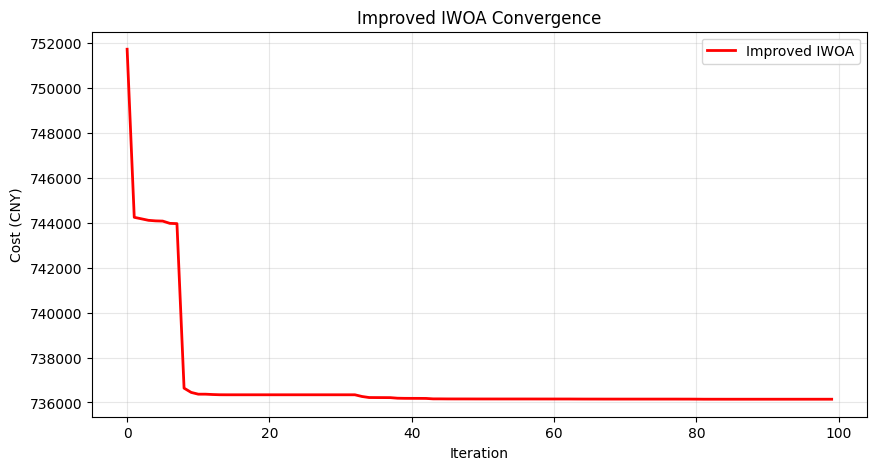

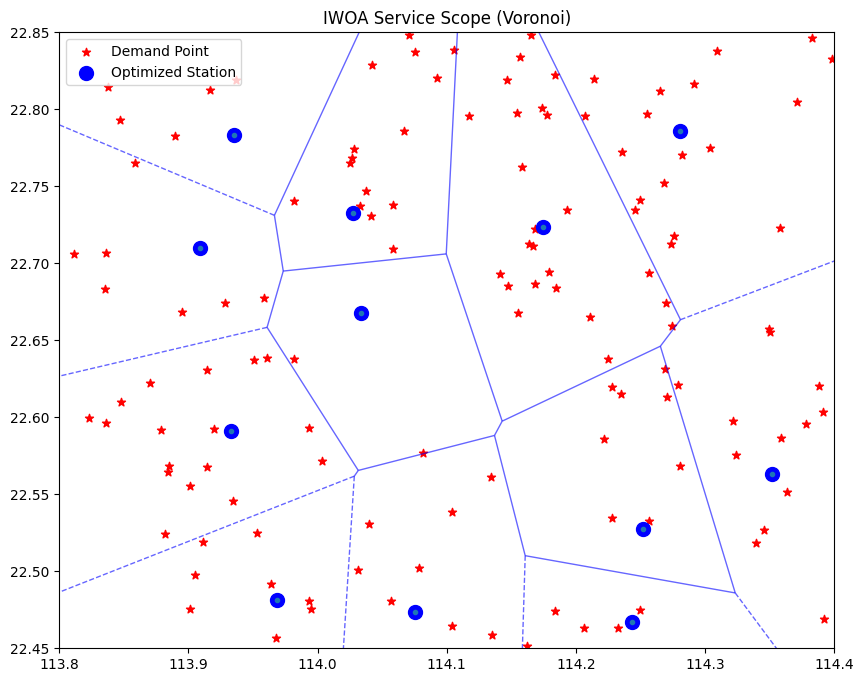

In [16]:
from IPython.display import clear_output
from scipy.spatial import Voronoi, voronoi_plot_2d

if __name__ == "__main__":
    
    # Generate Data
    dx = np.random.uniform(113.8, 114.4, 130)
    dy = np.random.uniform(22.45, 22.85, 130)
    mock_demand = np.column_stack((dx, dy))

    print("Running IWOA Simulation (Please wait)...")
    # Correctly capturing variables
    best_pos_iwoa, best_cost_iwoa, curve_iwoa = iwoa_solve(mock_demand, max_iter=100)

    # --- CLEAR SCREEN & SHOW RESULTS ---
    clear_output(wait  =True) 

    # 1. Print the Table
    print_financial_report(best_pos_iwoa, mock_demand)
    
    # 2. Plot Convergence Curve
    plt.figure(figsize=(10, 5))
    plt.plot(curve_iwoa, label='Improved IWOA', color='red', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Cost (CNY)')
    plt.title('Improved IWOA Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Plot Voronoi Map (Using CORRECT variable name)
    best_stations = best_pos_iwoa.reshape(12, 2)
    vor = Voronoi(best_stations)

    fig, ax = plt.subplots(figsize=(10, 8))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_alpha=0.6)
    ax.scatter(mock_demand[:, 0], mock_demand[:, 1], c='red', marker='*', label='Demand Point')
    ax.scatter(best_stations[:, 0], best_stations[:, 1], c='blue', marker='o', s=100, label='Optimized Station')

    ax.set_xlim(113.8, 114.4)
    ax.set_ylim(22.45, 22.85)
    ax.set_title("IWOA Service Scope (Voronoi)")
    ax.legend()
    plt.show()

In [17]:
def mini_standard_woa(demand_points, max_iter=500, pop_size=30, dim=28):
    # Standard WOA always uses 14 stations (dim=28)
    lb = np.array([113.8, 22.45]); ub = np.array([114.4, 22.85])
    lb_tiled = np.tile(lb, int(dim/2)); ub_tiled = np.tile(ub, int(dim/2))
    
    population = np.random.uniform(lb_tiled, ub_tiled, (pop_size, dim))
    fitness = np.array([calculate_fitness(ind.reshape(14,2), demand_points) for ind in population])
    
    best_idx = np.argmin(fitness)
    best_score = fitness[best_idx]
    best_whale = population[best_idx].copy()
    curve = []

    for t in range(max_iter):
        a = 2 - 2 * t / max_iter
        for i in range(pop_size):
            r1 = np.random.rand(); r2 = np.random.rand()
            A = 2 * a * r1 - a; C = 2 * r2; p = np.random.rand()
            if p < 0.5:
                if np.abs(A) < 1:
                    D = np.abs(C * best_whale - population[i])
                    population[i] = best_whale - A * D
                else:
                    rand_idx = np.random.randint(0, pop_size)
                    rand_whale = population[rand_idx]
                    D = np.abs(C * rand_whale - population[i])
                    population[i] = rand_whale - A * D
            else:
                dist = np.abs(best_whale - population[i])
                l = np.random.uniform(-1, 1)
                population[i] = dist * np.exp(l) * np.cos(2 * np.pi * l) + best_whale
        
        population = np.clip(population, lb_tiled, ub_tiled)
        fitness = np.array([calculate_fitness(ind.reshape(14,2), demand_points) for ind in population])
        
        current_idx = np.argmin(fitness)
        if fitness[current_idx] < best_score:
            best_score = fitness[current_idx]
            best_whale = population[current_idx].copy()
        curve.append(best_score)
        
    return best_score, curve

Running Comparison...
Starting IWOA Optimization for 100 iterations
Iteration 0: Best Cost = 752,104.55
Iteration 10: Best Cost = 736,867.51
Iteration 20: Best Cost = 736,650.10
Iteration 30: Best Cost = 736,649.87
Iteration 40: Best Cost = 736,649.67
Iteration 50: Best Cost = 736,649.66
Iteration 60: Best Cost = 736,649.66
Iteration 70: Best Cost = 736,649.66
Iteration 80: Best Cost = 736,649.66
Iteration 90: Best Cost = 736,649.66


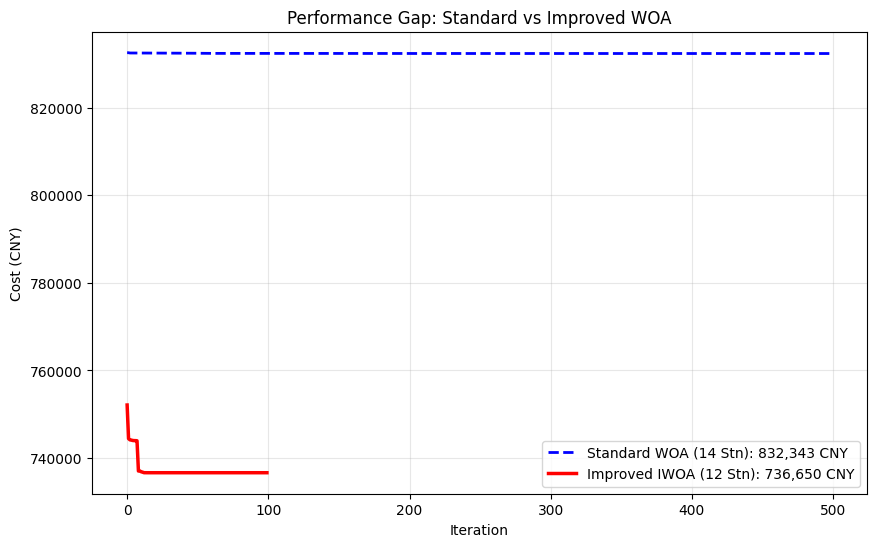

In [18]:
if __name__ == "__main__":
    np.random.seed(42)
    dx = np.random.uniform(113.8, 114.4, 130)
    dy = np.random.uniform(22.45, 22.85, 130)
    mock_demand = np.column_stack((dx, dy))

    print("Running Comparison...")
    woa_cost, woa_curve = mini_standard_woa(mock_demand, max_iter=500)
    _, iwoa_cost, iwoa_curve = iwoa_solve(mock_demand, max_iter=100, dim=24) # 12 Stations

    # --- PLOT ---
    plt.figure(figsize=(10, 6))
    
    # Standard WOA (Blue Dashed)
    plt.plot(woa_curve, label=f'Standard WOA (14 Stn): {woa_cost:,.0f} CNY', 
             color='blue', linestyle='--', linewidth=2)
    
    # Improved IWOA (Red Solid)
    plt.plot(iwoa_curve, label=f'Improved IWOA (12 Stn): {iwoa_cost:,.0f} CNY', 
             color='red', linewidth=2.5)

    plt.xlabel('Iteration')
    plt.ylabel('Cost (CNY)')
    plt.title('Performance Gap: Standard vs Improved WOA')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()